In [1]:
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm


import joblib
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

In [2]:
dataset = pd.read_csv('../data/dataset_labelled.tsv', sep='\t')

In [3]:
os.makedirs('../models/original', exist_ok=True)

In [4]:
def age_analyse(x):
    x = np.array(x[1:-1].split(', ')).astype('int')
    x_min = x.min()
    x_max = x.max()
    x_std = x.std()

    return pd.Series([x_min, x_max, x_std])

dataset[['age_min', 'age_max', 'age_std']] = dataset['people_age'].apply(age_analyse)

In [5]:
dataset.drop(['name', 'people_age', 'time_arrival'], inplace=True, axis=1)

In [6]:
dataset

,people_num,children_num,budget,nights,pool,spa,pet_friendly,lake,mountain,sport,...,family_rating,outdoor_rating,food_rating,leisure_rating,service_rating,user_score,label,age_min,age_max,age_std
0,3,0,138.798883,1,False,False,False,True,True,True,...,1.341722,1.977943,3.904595,2.760953,1.316275,0.615780,0.0,18.0,24.0,2.624669
1,3,0,138.798883,1,False,False,False,True,True,True,...,2.891142,1.937565,5.511516,0.081772,4.375542,3.902291,0.0,18.0,24.0,2.624669
2,3,0,138.798883,1,False,False,False,True,True,True,...,0.135038,0.943798,2.814335,1.348137,4.233355,1.995977,0.0,18.0,24.0,2.624669
3,3,0,138.798883,1,False,False,False,True,True,True,...,0.797574,1.716623,4.799925,3.574869,0.862926,1.873151,0.0,18.0,24.0,2.624669
4,3,0,138.798883,1,False,False,False,True,True,True,...,2.776166,1.409502,3.763358,1.729342,4.480145,4.818102,0.0,18.0,24.0,2.624669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,534.735442,3,True,True,False,True,False,False,...,2.545068,1.717019,2.250855,3.505579,2.928715,3.400542,0.0,23.0,36.0,6.500000
9996,2,0,534.735442,3,True,True,False,True,False,False,...,2.380126,4.237864,2.212638,3.541337,2.733679,3.489073,0.0,23.0,36.0,6.500000
9997,2,0,534.735442,3,True,True,False,True,False,False,...,0.074071,0.446839,2.863246,0.520269,1.111840,2.204813,0.0,23.0,36.0,6.500000
9998,2,0,534.735442,3,True,True,False,True,False,False,...,2.890286,2.265021,1.272934,1.447199,1.651927,2.813822,0.0,23.0,36.0,6.500000


In [7]:
dataset.columns

Index(['people_num', 'children_num', 'budget', 'nights', 'pool', 'spa',
       'pet_friendly', 'lake', 'mountain', 'sport', 'children', 'breakfast',
       'lunch', 'dinner', 'price', 'has_pool', 'has_spa', 'animals',
       'near_lake', 'near_mountains', 'has_sport', 'family_rating',
       'outdoor_rating', 'food_rating', 'leisure_rating', 'service_rating',
       'user_score', 'label', 'age_min', 'age_max', 'age_std'],
      dtype='object')

In [8]:
X = dataset.drop('label', axis=1).values
Y = dataset['label'].values

In [9]:
X.shape, Y.shape

((10000, 30), (10000,))

In [10]:
seed=42

In [11]:
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.2, random_state=seed)
Y_tr = Y_tr.reshape(-1, 1)
Y_ts = Y_ts.reshape(-1, 1)

In [12]:
X_tr.shape, Y_tr.shape, X_ts.shape, Y_ts.shape

((8000, 30), (8000, 1), (2000, 30), (2000, 1))

In [13]:
Y_tr.mean(), Y_ts.mean()

(np.float64(0.08725), np.float64(0.081))

In [14]:
mms = MinMaxScaler()
X_tr = mms.fit_transform(X_tr)
X_ts = mms.transform(X_ts)

In [15]:
joblib.dump(mms,'../models/original/mms.model')

['../models/original/mms.model']

<Axes: >

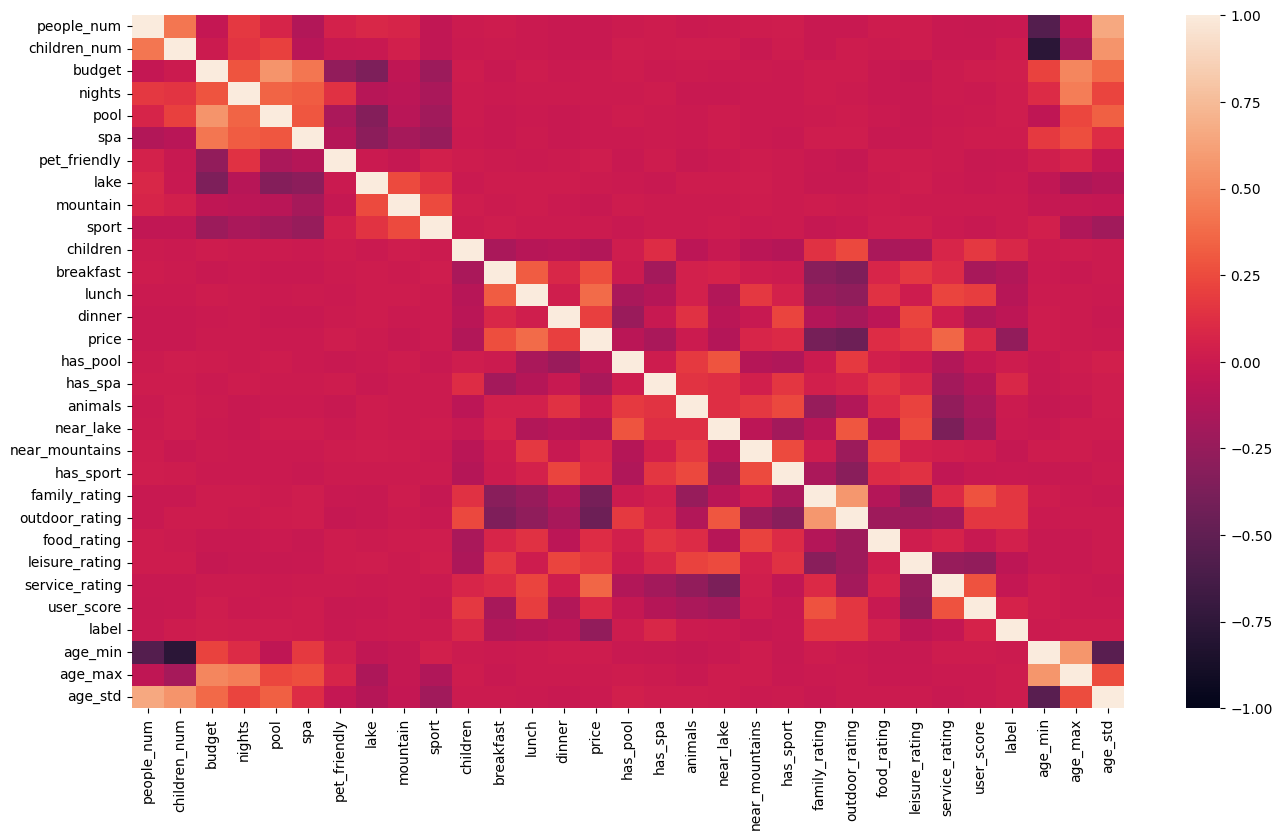

In [16]:
plt.figure(figsize=(16,9))
sns.heatmap(dataset.corr(method='spearman'), vmin=-1.0, vmax=1.0)

In [17]:
skb = SelectKBest(chi2, k=20)
skb.fit(X_tr, Y_tr)
X_tr = skb.transform(X_tr)
X_ts = skb.transform(X_ts)

In [18]:
joblib.dump(skb, '../models/original/skb.model')

['../models/original/skb.model']

In [19]:
with open('../models/original/metadata.json', 'w+') as f:
    json.dump({
        'features': dataset.drop('label', axis=1).columns.to_list(),
        'x_input':  X.shape[1],
        'x_output': X_tr.shape[1],
        'n_records': X_tr.shape[0],
        'seed': seed,
    }, f, indent=4)

In [20]:
class Model(nn.Module):

    def __init__(self, input_size):
        super(Model, self).__init__()
        
        self.layers = [
            nn.Linear(input_size, 64),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        ]

        self.net = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.net(x)


In [21]:
epochs = 100
batch_size = 8
n, features = X_tr.shape
batch_count = int(n / batch_size)

frac1 = 0.5

model = Model(features).to('cpu')

optimizer = torch.optim.Adam(model.parameters())

r = np.random.default_rng(seed)

criterion = nn.BCELoss()

loss_tr, acc_tr, pre_tr, rec_tr, f1s_tr, auc_tr = [], [], [], [], [], []
loss_ts, acc_ts, pre_ts, rec_ts, f1s_ts, auc_ts = [], [], [], [], [], []
loss_best = []

x_ts = torch.FloatTensor(X_ts).to('cpu')
y_ts = torch.FloatTensor(Y_ts).to('cpu')

best_loss = 1.0
best_model_path = '../models/original/best_neuralnet.model'
model_path = '../models/original/neuralnet.model'

t =  tqdm(range(epochs * batch_count))
for epoch in range(epochs):
    # train
    model.train()

    loss_btc = []
    y_preds, y_sels = [], []
    for batch in range(batch_count):
        mask = (Y_tr == 0).reshape(-1)

        X_tr_0 = X_tr[mask]
        X_tr_1 = X_tr[~mask]

        Y_tr_0 = Y_tr[mask]
        Y_tr_1 = Y_tr[~mask]

        n0, _ = X_tr_0.shape
        n1, _ = X_tr_1.shape

        sample_ids_0 = r.choice(n0, size=min(n, int(batch_size * (1 - frac1))))
        sample_ids_1 = r.choice(n1, size=min(n, int(batch_size * frac1)))

        X_tr_sel = np.vstack((X_tr_0[sample_ids_0], X_tr_1[sample_ids_1]))
        Y_tr_sel = np.vstack((Y_tr_0[sample_ids_0], Y_tr_1[sample_ids_1]))

        x = torch.FloatTensor(X_tr_sel).to('cpu')
        y = torch.FloatTensor(Y_tr_sel).to('cpu')

        out = model(x)
        loss = criterion(out, y)
        l_val = loss.item()
        
        loss_btc.append(l_val)

        t.update()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = out.detach().numpy()
        y_preds.append(pred)
        y_sels.append(Y_tr_sel)

    y_preds = np.array(y_preds).reshape(-1)
    y_sels = np.array(y_sels).reshape(-1)

    auc_tr.append(roc_auc_score(y_sels, y_preds))

    y_preds = (y_preds > 0.5).astype('int')

    loss_btc_mean = np.array(loss_btc).mean()
    loss_tr.append(loss_btc_mean)
    acc_tr.append(accuracy_score(y_sels, y_preds))
    pre_tr.append(recall_score(y_sels, y_preds, zero_division=0))
    rec_tr.append(precision_score(y_sels, y_preds, zero_division=0))
    f1s_tr.append(f1_score(y_sels, y_preds, zero_division=0))

    if loss_btc_mean < best_loss:
        best_loss = loss_btc_mean
        torch.save(model.state_dict(), best_model_path)
    
    loss_best.append(best_loss)

    model.eval()

    # evaluate test
    out = model(x_ts)

    loss = criterion(out, y_ts)
    l_val = loss.item()

    loss_ts.append(l_val)

    pred_ts = out.detach().numpy()

    auc_ts.append(roc_auc_score(y_sels, y_preds))

    pred_ts = (pred_ts > 0.5).astype('int')

    acc_ts.append(accuracy_score(Y_ts, pred_ts))
    pre_ts.append(recall_score(Y_ts, pred_ts, zero_division=0))
    rec_ts.append(precision_score(Y_ts, pred_ts, zero_division=0))
    f1s_ts.append(f1_score(Y_ts, pred_ts, zero_division=0))

    t.set_postfix(Epoch=f'{epoch:3}', Loss=l_val, BestLoss=best_loss, TestLoss=loss_ts[-1])
    t.update()

torch.save(model.state_dict(), model_path)

100099it [02:35, 648.33it/s, BestLoss=0.256, Epoch=99, Loss=0.464, TestLoss=0.464]                           

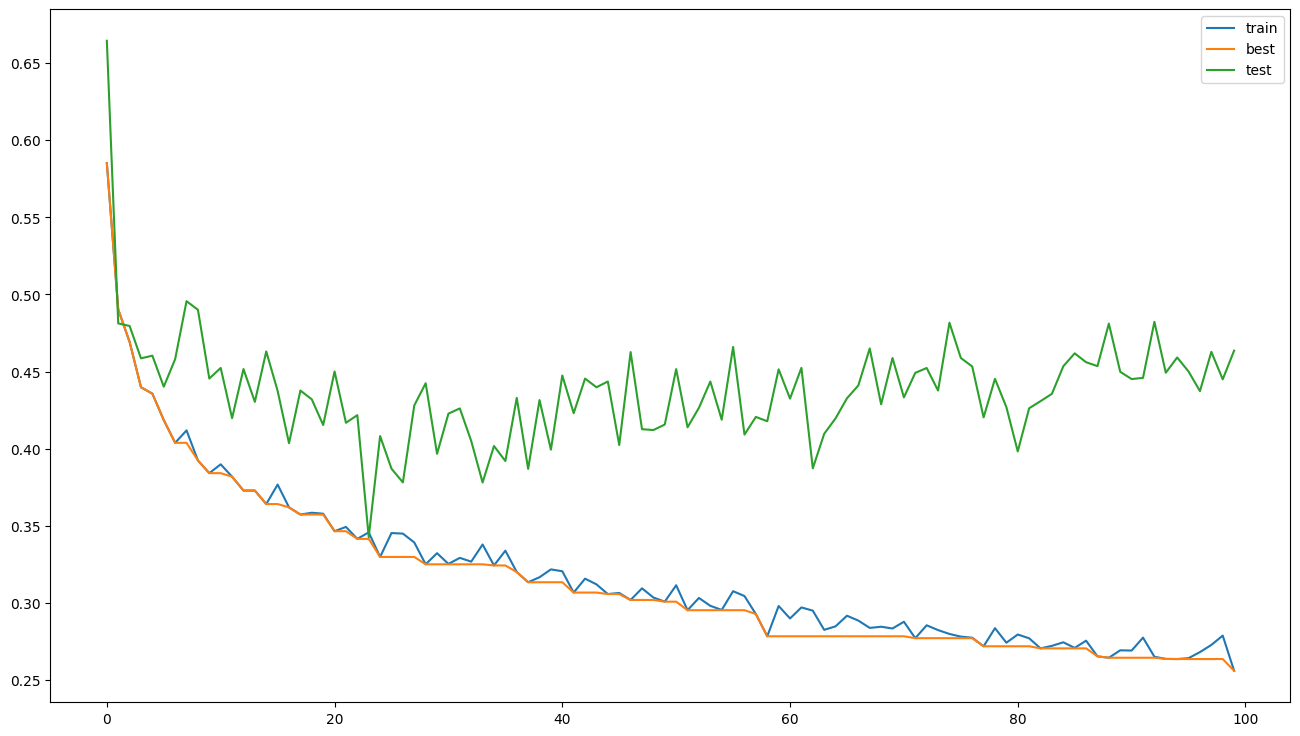

In [22]:
xs = np.arange(epochs)

plt.figure(figsize=(16,9))
plt.plot(xs, loss_tr, label='train')
plt.plot(xs, loss_best, label='best')
plt.plot(xs, loss_ts, label='test')
plt.legend()

/tmp/ipykernel_2220519/3780218367.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


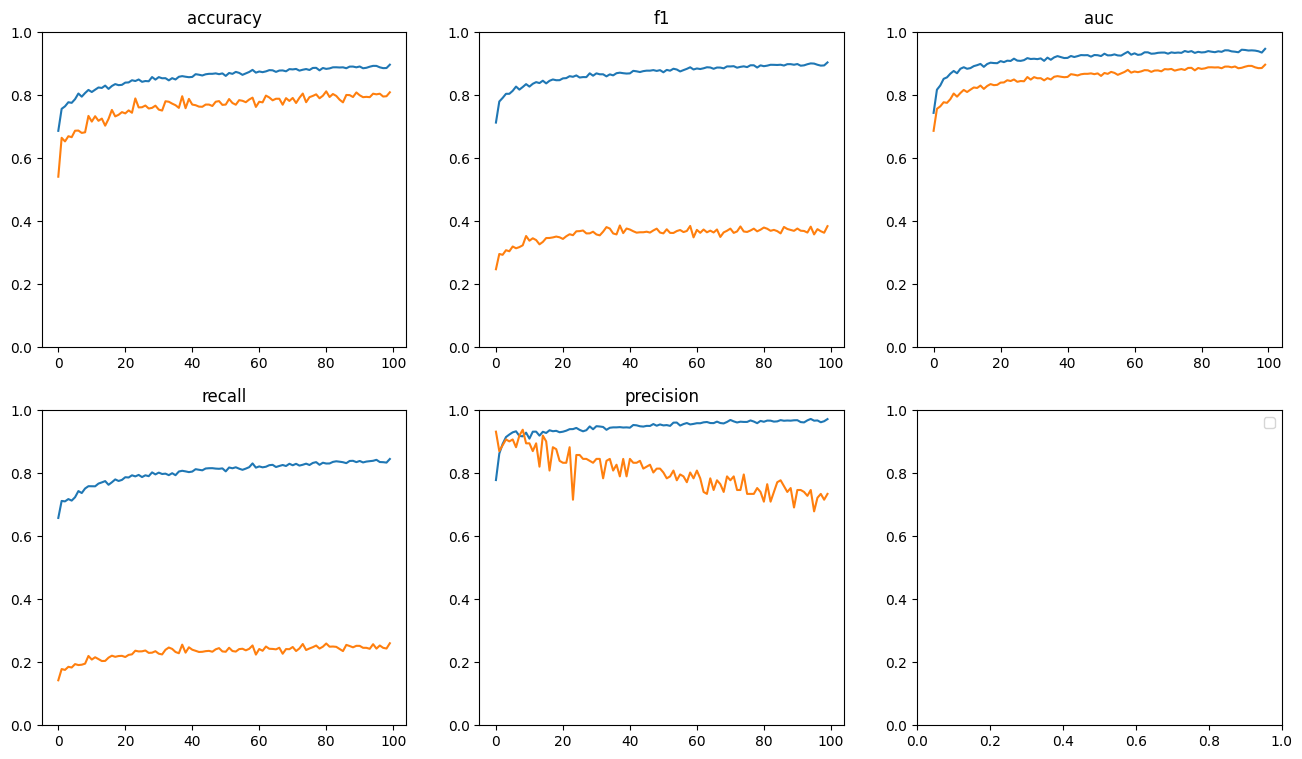

In [23]:
xs = np.arange(epochs)

f, ((a1, a2, a3), (a4, a5, a6)) = plt.subplots(2, 3, figsize=(16,9))
a1.plot(xs, acc_tr, label='train')
a1.plot(xs, acc_ts, label='test')
a1.set_title('accuracy')
a1.set_ylim((0,1))

a2.plot(xs, f1s_tr, label='train')
a2.plot(xs, f1s_ts, label='test')
a2.set_title('f1')
a2.set_ylim((0,1))

a3.plot(xs, auc_tr, label='train')
a3.plot(xs, auc_ts, label='test')
a3.set_title('auc')
a3.set_ylim((0,1))

a4.plot(xs, rec_tr, label='train')
a4.plot(xs, rec_ts, label='test')
a4.set_title('recall')
a4.set_ylim((0,1))

a5.plot(xs, pre_tr, label='train')
a5.plot(xs, pre_ts, label='test')
a5.set_title('precision')
a5.set_ylim((0,1))

plt.legend()

In [24]:
print('TRAIN')
print('accuracy  ', acc_tr[-1])
print('auc roc:  ', auc_tr[-1])
print('f1 score: ', f1s_tr[-1])
print('precision:', rec_tr[-1])
print('recall:   ', pre_tr[-1])
print()
print('TEST')
print('accuracy  ', acc_ts[-1])
print('auc roc:  ', auc_ts[-1])
print('f1 score: ', f1s_ts[-1])
print('precision:', pre_ts[-1])
print('recall:   ', rec_ts[-1])

TRAIN
accuracy   0.897125
auc roc:   0.947477125
f1 score:  0.9042911966507734
precision: 0.8454011741682974
recall:    0.972

TEST
accuracy   0.8095
auc roc:   0.8971250000000001
f1 score:  0.38449111470113084
precision: 0.7345679012345679
recall:    0.2603938730853392


100100it [02:50, 648.33it/s, BestLoss=0.256, Epoch=99, Loss=0.464, TestLoss=0.464]